#  MLP to predict the re-enrollment of a student

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Importing the data base
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Function to plot learning curves

In [ ]:
import matplotlib.pyplot as plt

# Updated plot_learning_curves function to include test metrics
def plot_learning_curves(
    train_losses, val_losses, test_losses,
    train_accuracies, val_accuracies, test_accuracies,
    train_f1_scores, val_f1_scores, test_f1_scores
):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Negative F1 Score
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_f1_scores, label="Training F1 Score")
    plt.plot(epochs, val_f1_scores, label="Validation F1 Score")
    plt.plot(epochs, test_f1_scores, label="Test F1 Score")
    plt.title("Negative Class F1 Score vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

## Function to plot ROC curves

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test):
    """
    Plots the ROC curve for the model predictions.

    Parameters:
        model (torch.nn.Module): The trained PyTorch model.
        X_test (torch.Tensor): Test feature data (torch.Tensor).
        y_test (torch.Tensor): True labels for the test data (torch.Tensor).
    """
    model.eval()
    with torch.no_grad():
        # Get predicted probabilities
        y_probs = model(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        auc_score = roc_auc_score(y_true, y_probs)

        # Plot the ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

## Data pre-processing, model definition and metrics computation function

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

# Load and preprocess data
# Adjust path as needed when not executing the code in Google Colab
file_path = '/content/drive/My Drive/casestudy_dropout.dta'
data = pd.read_stata(file_path)

# Step 1: Impute missing values in GPAin2021 with the mean
imputer = SimpleImputer(strategy='mean')
data['GPAin2021'] = imputer.fit_transform(data[['GPAin2021']])

# Step 2: Extract features from DropoutDate
data['DropoutMonth'] = data['DropoutDate'].dt.month
data['DropoutDay'] = data['DropoutDate'].dt.day
data.drop(columns=['DropoutDate'], inplace=True)

# Step 3: Normalize numerical features
numerical_features = [
    'SchoolGrade2022', 'DayOfWeekDroppedOut', 'Age', 'GPAin2021', 'AttendanceIn2021',
    'SchoolDaysFromMay302022'
]
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Step 4: Define target and features
target = 'EnrolledByAug312022'
X = data.drop(columns=[target, 'IDstudent', 'IDschool', 'GraduatedIn2022'])  # Exclude IDs and target, GraduatedIn2022 was excluded to prevent data leakage
y = data[target]

# Step 5: Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.output = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

# Function to compute metrics
def compute_metrics(model, criterion, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, y)
        predictions = (outputs >= 0.5).float()

        y_true = y.cpu().numpy()
        y_pred = predictions.cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        f1_negative = f1_score(y_true, y_pred, pos_label=0)

    return loss.item(), accuracy, f1_negative

## Training the MLP without balanced batches

In this context, the negative class (EnrolledByAug312022=0) F1 score is an important metric to measure wether the model accurately identifies students at risk of dropping out.

Epoch [1/200] Train Loss: 13.2401, Val Loss: 13.0460, Test Loss: 16.0309, Train Acc: 0.7941, Val Acc: 0.7933, Test Acc: 0.7629, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000
Epoch [2/200] Train Loss: 14.2554, Val Loss: 13.9679, Test Loss: 17.1498, Train Acc: 0.7941, Val Acc: 0.7933, Test Acc: 0.7629, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000
Epoch [3/200] Train Loss: 14.7959, Val Loss: 14.6268, Test Loss: 17.8508, Train Acc: 0.7941, Val Acc: 0.7933, Test Acc: 0.7629, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000
Epoch [4/200] Train Loss: 15.0807, Val Loss: 14.7174, Test Loss: 18.0342, Train Acc: 0.7941, Val Acc: 0.7933, Test Acc: 0.7629, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000
Epoch [5/200] Train Loss: 15.0004, Val Loss: 14.6861, Test Loss: 17.9520, Train Acc: 0.7941, Val Acc: 0.7933, Test Acc: 0.7629, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000
Epoch [6/200] Train Loss: 14.7250, Val Loss: 14.5387, Test Loss: 17.8552, Train Acc: 0.7941, Val Acc: 0.7933, 

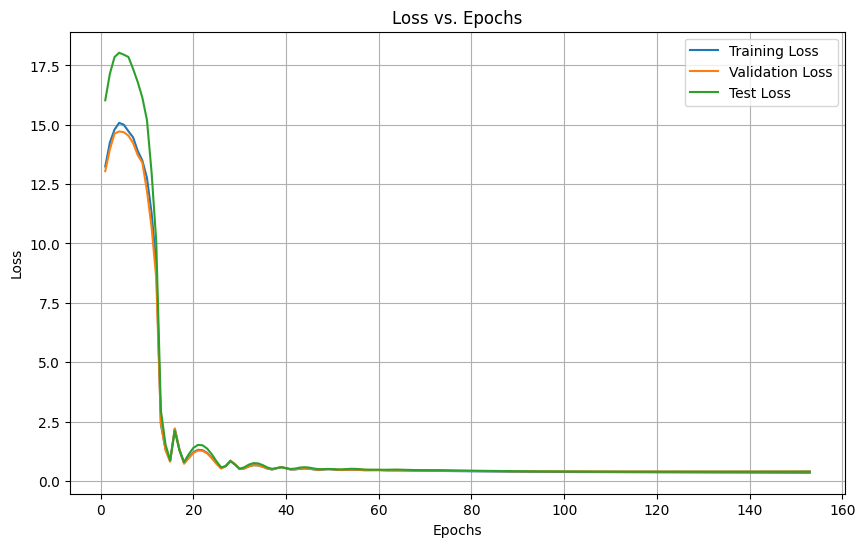

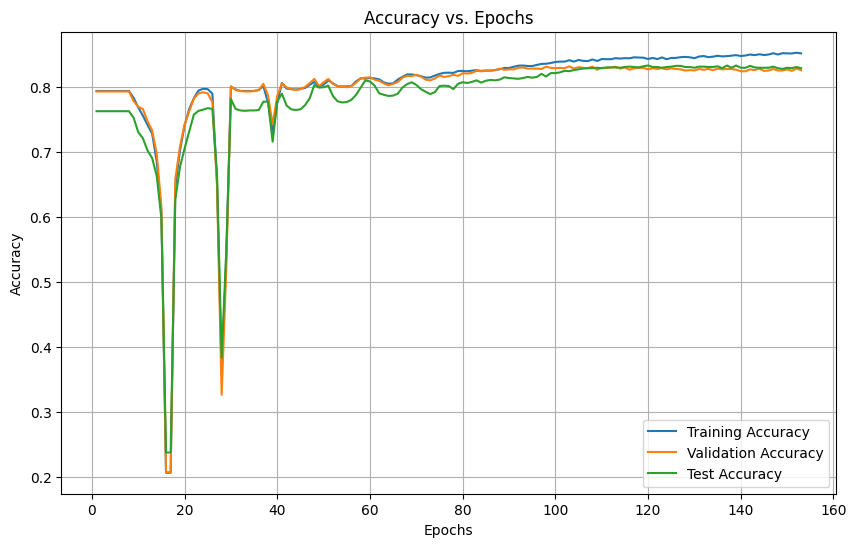

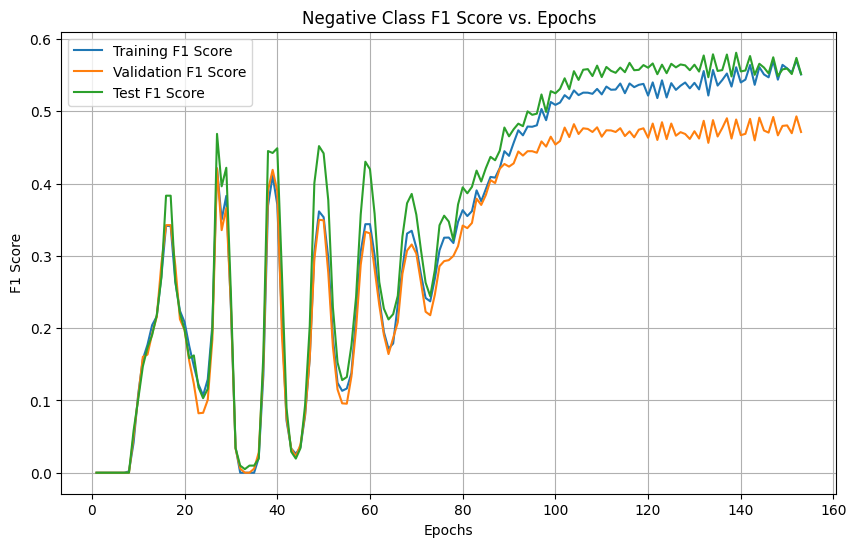

In [ ]:
def train_model_with_test_metrics(
    X_train, y_train, X_val, y_val, X_test, y_test, epochs=150, patience
):
    input_size = X_train.shape[1]
    model = MLP(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    train_f1_scores, val_f1_scores, test_f1_scores = [], [], []

    best_val_accuracy = 0
    best_val_f1 = 0
    best_test_accuracy = 0
    best_test_f1 = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss, train_acc, train_f1 = compute_metrics(model, criterion, X_train, y_train)
        val_loss, val_acc, val_f1 = compute_metrics(model, criterion, X_val, y_val)
        test_loss, test_acc, test_f1 = compute_metrics(model, criterion, X_test, y_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)
        test_f1_scores.append(test_f1)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}, "
            f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}"
        )

        # Track the best validation and test metrics
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_test_f1 = test_f1
            best_model_state = model.state_dict()

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_test_accuracy = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Print the best validation and test metrics
    print("\nBest Metrics:")
    print(f"Validation Accuracy: {best_val_accuracy:.4f}, Validation F1 (negative): {best_val_f1:.4f}")
    print(f"Test Accuracy: {best_test_accuracy:.4f}, Test F1 (negative): {best_test_f1:.4f}")

    return (
        model, train_losses, val_losses, test_losses,
        train_accuracies, val_accuracies, test_accuracies,
        train_f1_scores, val_f1_scores, test_f1_scores
    )


# Train the model
(
    model, train_losses, val_losses, test_losses,
    train_acc, val_acc, test_acc,
    train_f1, val_f1, test_f1
) = train_model_with_test_metrics(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor,
    epochs=150, patience=50)

# Plot learning curves with test metrics
plot_learning_curves(
    train_losses, val_losses, test_losses,
    train_acc, val_acc, test_acc,
    train_f1, val_f1, test_f1
)

### ROC validation set

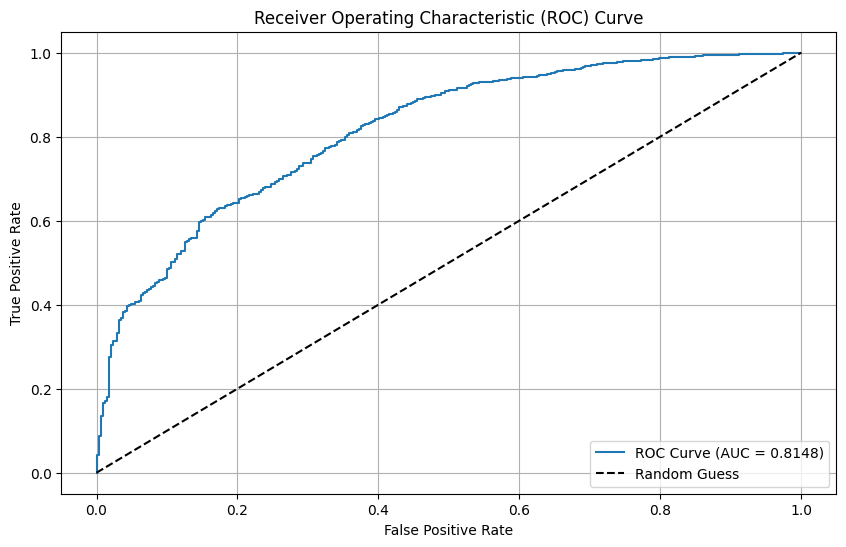

In [ ]:
# Compute and plot ROC for validation set
plot_roc_curve(model, X_val_tensor, y_val_tensor)

### ROC test set

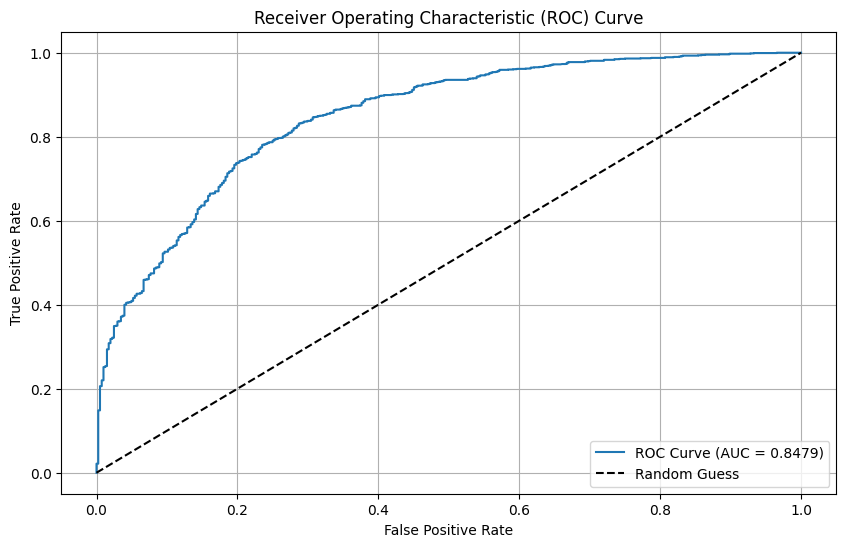

In [ ]:
# Compute and plot RC for test set
plot_roc_curve(model, X_test_tensor, y_test_tensor)

## Training the MLP using balanced batches

Since the students that rejoin the educational system (EnrolledByAug312022=1) are overrepresented in the dataset, we train the MLP with equilibrated batches where the samples are distributed equally between the two target classes.

As expected, this leads to a higher negative class F1 score (test data set: 62.14 vs. 57.40), which indicates that this model can more reliably identify the students that are at risk of permanently abandoning the educational system.

Epoch [1/150] Train Loss: 0.9361, Val Loss: 0.5445, Test Loss: 0.5362, Train Acc: 0.6350, Val Acc: 0.7745, Test Acc: 0.7700, Train F1: 0.6498, Val F1: 0.5351, Test F1: 0.5730
Epoch [2/150] Train Loss: 0.5387, Val Loss: 0.5225, Test Loss: 0.4988, Train Acc: 0.7358, Val Acc: 0.7317, Test Acc: 0.7582, Train F1: 0.7286, Val F1: 0.5274, Test F1: 0.6008
Epoch [3/150] Train Loss: 0.5134, Val Loss: 0.6225, Test Loss: 0.5809, Train Acc: 0.7546, Val Acc: 0.6735, Test Acc: 0.7218, Train F1: 0.7559, Val F1: 0.4964, Test F1: 0.5849
Epoch [4/150] Train Loss: 0.5185, Val Loss: 0.6787, Test Loss: 0.6490, Train Acc: 0.7446, Val Acc: 0.6213, Test Acc: 0.6479, Train F1: 0.7437, Val F1: 0.4777, Test F1: 0.5413
Epoch [5/150] Train Loss: 0.4981, Val Loss: 0.6007, Test Loss: 0.5576, Train Acc: 0.7532, Val Acc: 0.6894, Test Acc: 0.7312, Train F1: 0.7458, Val F1: 0.4986, Test F1: 0.5881
Epoch [6/150] Train Loss: 0.4899, Val Loss: 0.4896, Test Loss: 0.4673, Train Acc: 0.7587, Val Acc: 0.7516, Test Acc: 0.7793, 

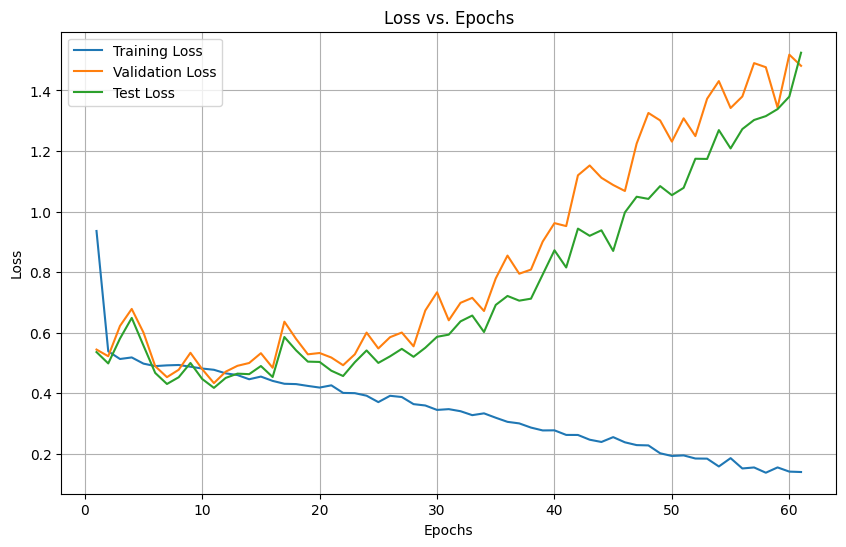

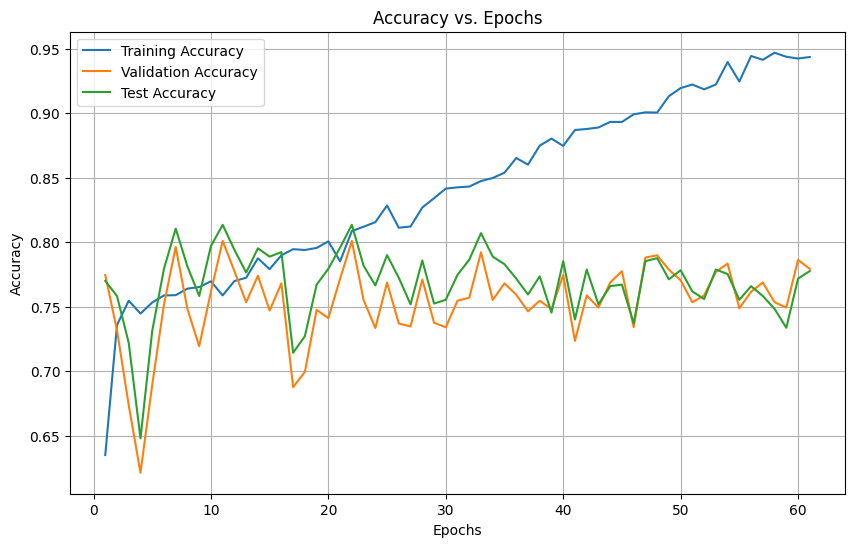

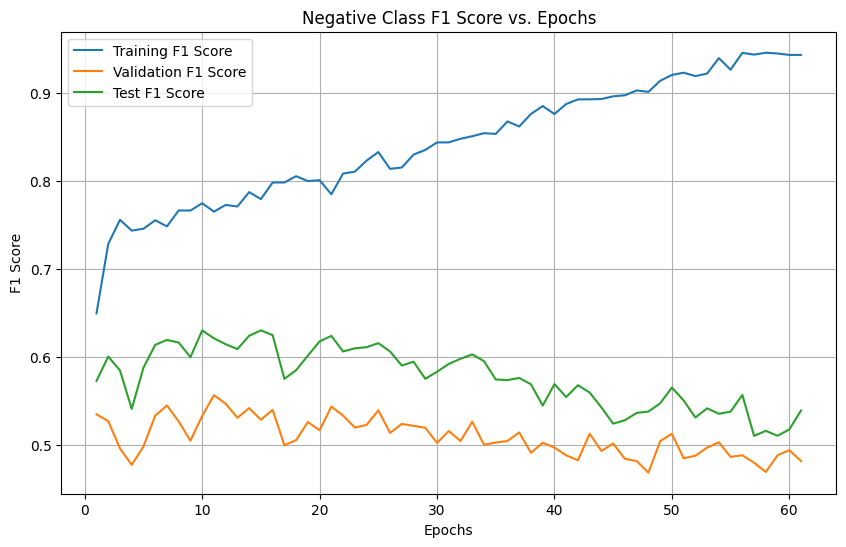

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Prepare DataLoader with balanced batches
# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Compute class weights
class_counts = y_train_tensor.view(-1).long().bincount()
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train_tensor.view(-1).long()]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)


# Updated training function
def train_model_balanced_with_test_metrics(train_loader, X_val, y_val, X_test, y_test, epochs, patience):
    input_size = X_val.shape[1]  # Infer input size from validation set
    model = MLP(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    train_f1_scores, val_f1_scores, test_f1_scores = [], [], []

    best_val_accuracy = 0
    best_val_f1 = 0
    best_test_accuracy = 0
    best_test_f1 = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_preds, epoch_labels = [], []

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predictions = (outputs >= 0.5).float()
            epoch_preds.extend(predictions.cpu().numpy())
            epoch_labels.extend(y_batch.cpu().numpy())

        # Compute training metrics
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracy = accuracy_score(epoch_labels, (np.array(epoch_preds) >= 0.5).astype(int))
        train_f1_negative = f1_score(epoch_labels, np.array(epoch_preds), pos_label=0)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1_negative)

        # Compute validation metrics
        val_loss, val_acc, val_f1 = compute_metrics(model, criterion, X_val, y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        # Compute test metrics
        test_loss, test_acc, test_f1 = compute_metrics(model, criterion, X_test, y_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1_scores.append(test_f1)

        # Log metrics
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}, "
            f"Train F1: {train_f1_negative:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}"
        )

        # Track the best validation metrics and corresponding test metrics
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_test_f1 = test_f1
            best_model_state = model.state_dict()

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_test_accuracy = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Print the best validation and test metrics
    print("\nBest Metrics:")
    print(f"Validation Accuracy: {best_val_accuracy:.4f}, Validation F1 (negative): {best_val_f1:.4f}")
    print(f"Test Accuracy: {best_test_accuracy:.4f}, Test F1 (negative): {best_test_f1:.4f}")

    return (
        model, train_losses, val_losses, test_losses,
        train_accuracies, val_accuracies, test_accuracies,
        train_f1_scores, val_f1_scores, test_f1_scores
    )


# Train the model with test metrics
epochs = 150
patience = 50

(
    model, train_losses, val_losses, test_losses,
    train_acc, val_acc, test_acc,
    train_f1, val_f1, test_f1
) = train_model_balanced_with_test_metrics(
    train_loader, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, epochs, patience)

# Plot learning curves with test metrics
plot_learning_curves(
    train_losses, val_losses, test_losses,
    train_acc, val_acc, test_acc,
    train_f1, val_f1, test_f1
)

### ROC validation set

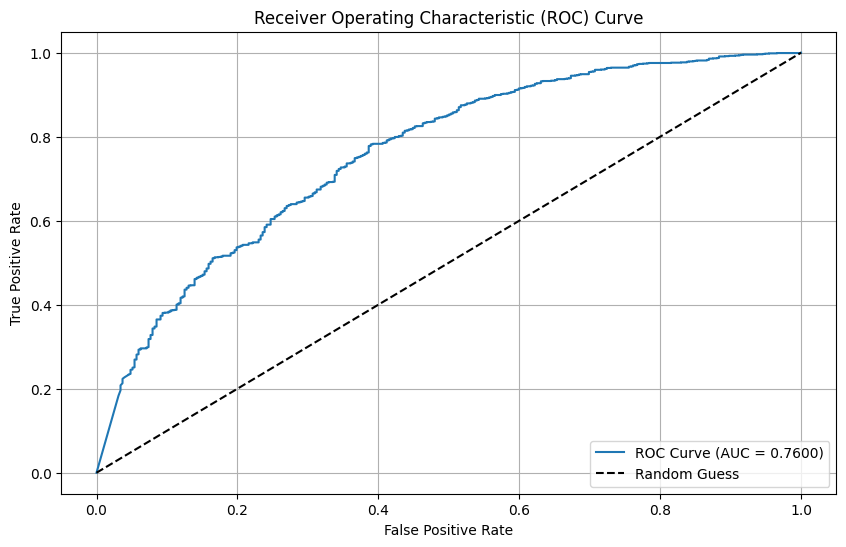

In [ ]:
# Plot ROC curves for validation set
plot_roc_curve(model, X_val_tensor, y_val_tensor)

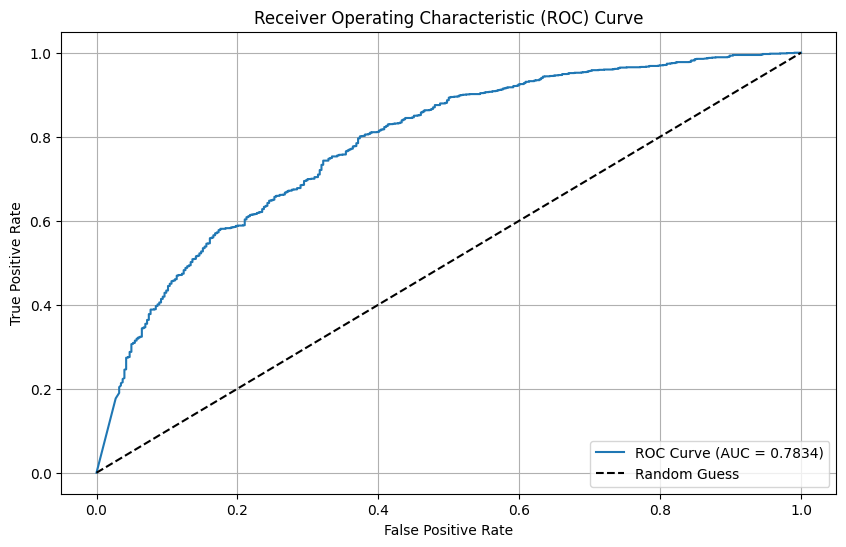

In [ ]:
# Plot ROC curves for test set
plot_roc_curve(model, X_test_tensor, y_test_tensor)